In [1]:
import re

import pandas as pd
from pathlib import Path
from ploting import *

In [2]:
root_path = "horeka"

In [3]:
name_re = re.compile("(weak|strong)_scaling-d_(\d+)-n_(\d+)-([\w_]+)_comm-(gpu|cpu)-nodes_(\d+)")

In [4]:
time_re = re.compile("DURATION:\s*(\d+(\.\d+)?(e[+-]\d+)?)")

In [12]:
def create_df(path):
    data = []
    for file in Path(f"{path}/data").iterdir():
        if m := name_re.search(file.name):
            with open(file, "r") as input:
                if t_m := time_re.search(input.read()):
                    duration = t_m.group(1)
                    data.append({"scaling": m.group(1), "dim": m.group(2), "n": m.group(3), "comm_pattern": m.group(4),
                                 "type": m.group(5), "nodes": m.group(6), "time": duration})
    df = pd.DataFrame(data)
    df = df[df.comm_pattern == "optimal"]
    return df.drop(columns=["scaling", "type", "comm_pattern"]).astype({"dim": int, "n": int, "nodes": int, "time": float})

In [13]:
def pivot(df):
    piv = df.pivot(index="nodes", columns=["dim", "n"], values="time")
    return piv[piv.columns.sort_values()]

In [14]:
df_with_guard = create_df("crusher-guard")
df_with_guard = pivot(df_with_guard)
df_with_guard

dim           2                                                 3            \
n       100       1000      10000     100000    1000000   100       1000      
nodes                                                                         
1      0.000011  0.000044  0.000357  0.003481  0.034836  0.000022  0.000115   
2      0.000010  0.000047  0.000341  0.003304  0.032904  0.000022  0.000113   
4      0.000010  0.000044  0.000394  0.003655  0.034147  0.000022  0.000115   
8      0.000010  0.000068  0.000365  0.003749  0.034958  0.000025  0.000116   
16     0.000011  0.000048  0.000387  0.003786  0.044328  0.000028  0.000119   
32     0.000012  0.000048  0.000496  0.003716  0.036141  0.000025  0.000121   
64     0.000015  0.000075  0.000624  0.006064  0.052012  0.000032  0.000188   
128    0.000016  0.000077  0.000624  0.004023  0.037092  0.000035  0.000189   

dim                                  
n       10000     100000    1000000  
nodes                                
1      0.001117  0.010930  0.111355  
2      0.001093  0.010045  0.101644  
4      0.001150  0.010761  0.111483  
8      0.001152  0.010757  0.111585  
16     0.001186  0.010959  0.112186  
32     0.001204  0.011039  0.111323  
64     0.001932  0.017560  0.143879  
128    0.001941  0.011786  0.112899

In [15]:
df_without_guard = create_df("crusher")
df_without_guard = pivot(df_without_guard)
df_without_guard

dim           2                                                 3            \
n       100       1000      10000     100000    1000000   100       1000      
nodes                                                                         
1      0.000024  0.000026  0.000033  0.000051  0.000280  0.000026  0.000029   
2      0.000025  0.000027  0.000032  0.000050  0.000280  0.000027  0.000029   
4      0.000027  0.000030  0.000033  0.000051  0.000281  0.000029  0.000030   
8      0.000034  0.000031  0.000037  0.000050  0.000279  0.000032  0.000033   
16     0.000035  0.000032  0.000037  0.000052  0.000281  0.000033  0.000034   
32     0.000039  0.000033  0.000038  0.000051  0.000281  0.000033  0.000035   
64     0.000046  0.000034  0.000039  0.000055  0.000282  0.000035  0.000035   
128    0.000061  0.000037  0.000041  0.000057  0.000283  0.000037  0.000038   

dim                                  
n       10000     100000    1000000  
nodes                                
1      0.000040  0.000076  0.000579  
2      0.000040  0.000077  0.000579  
4      0.000041  0.000077  0.000580  
8      0.000044  0.000078  0.000580  
16     0.000046  0.000080  0.000582  
32     0.000046  0.000081  0.000580  
64     0.000047  0.000083  0.000581  
128    0.000050  0.000085  0.000583

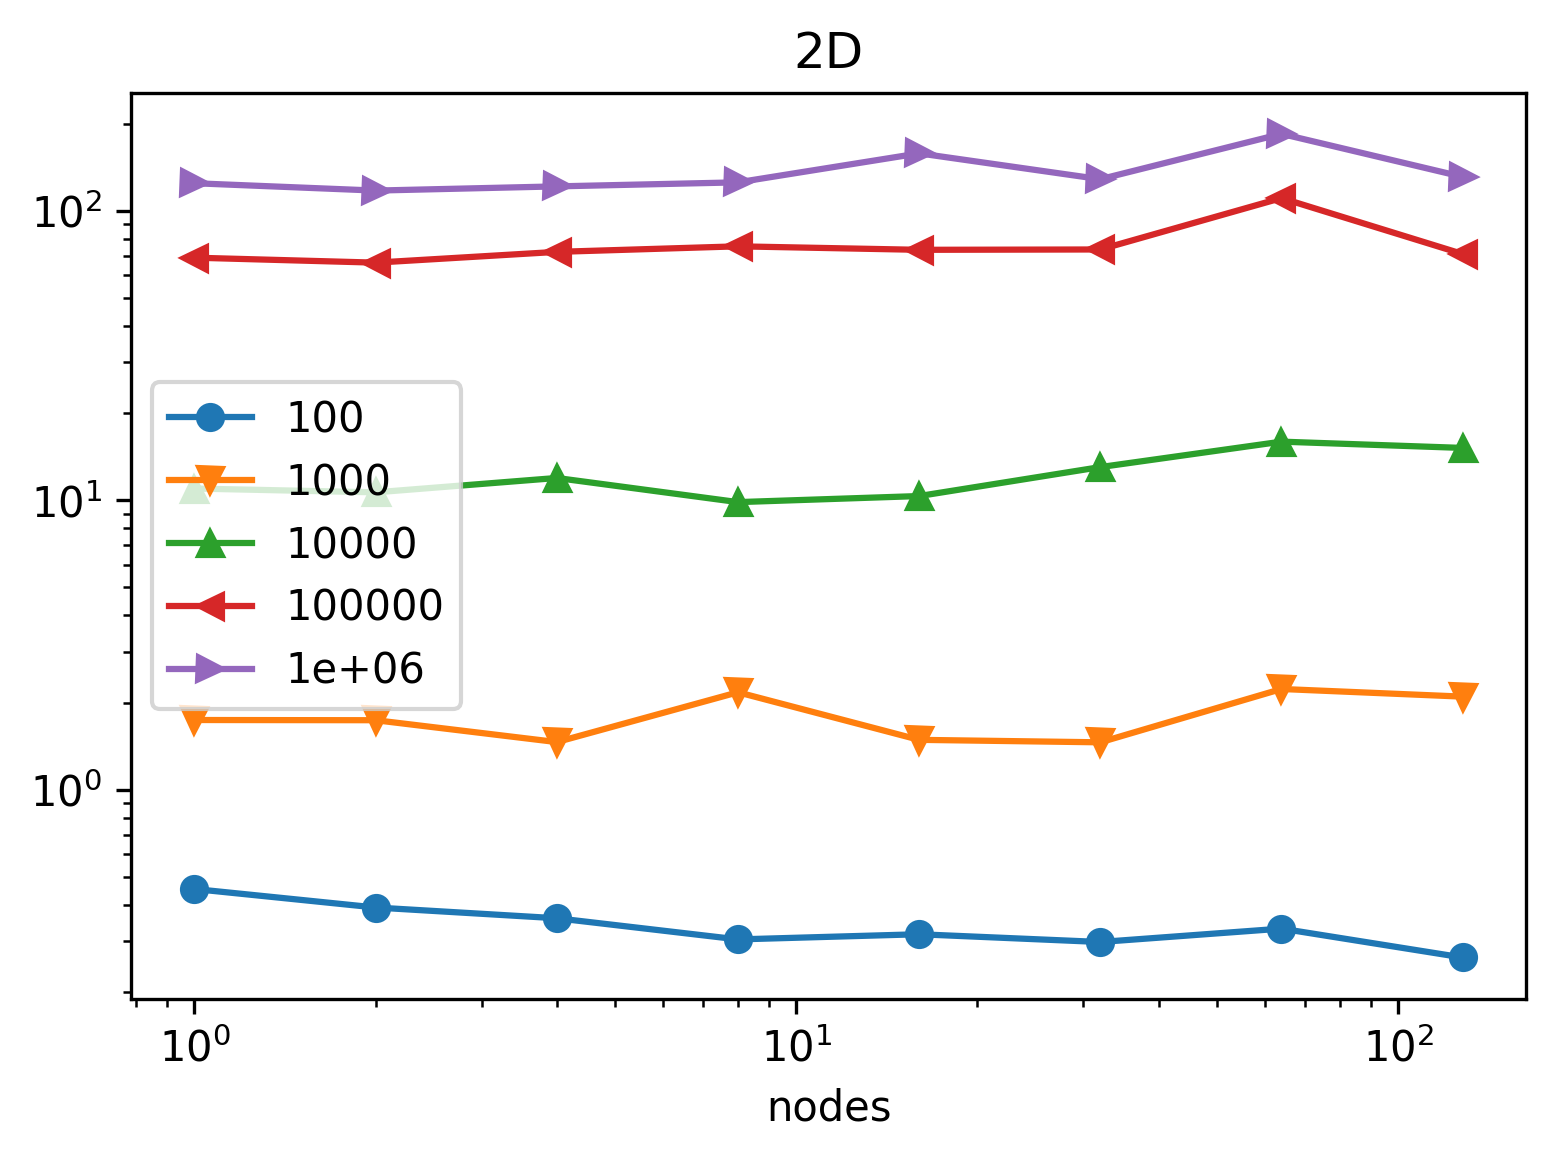

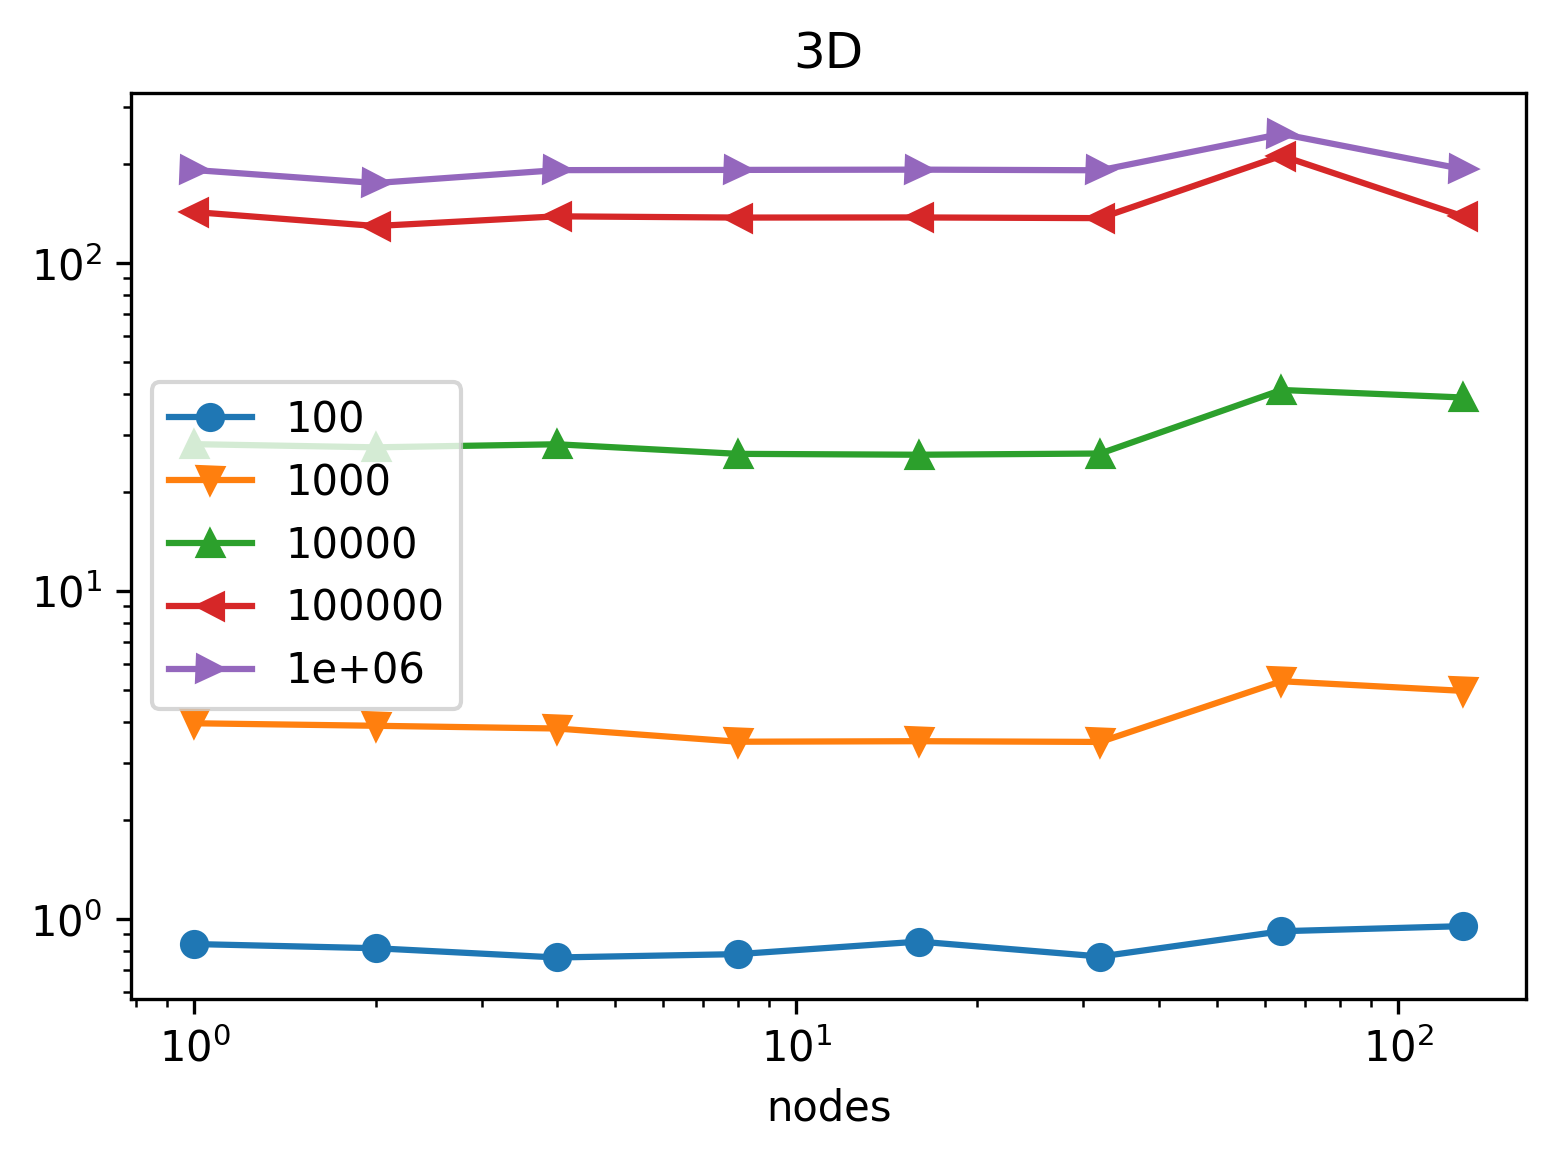

In [16]:
df = df_with_guard / df_without_guard
for dim in df_without_guard.columns.levels[0]:
    fig, ax = plt.subplots(dpi=300)
    _df = df[dim]
    ax.set_prop_cycle(default_cycler)
    ax.set_title(f"{dim}D")
    _df.plot(ax=ax, legend=False, logx=True, logy=True)
    ax.legend([f"{n:g}" for n in df.columns.levels[1]])
    #fig.savefig(f"runtime-mpi-comparison-{dim}d.png")